In [57]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mias-mammography/Info.txt
/kaggle/input/mias-mammography/all_mias_scans.h5
/kaggle/input/mias-mammography/all-mias.tar.gz
/kaggle/input/mias-mammography/all-mias/mdb152.pgm
/kaggle/input/mias-mammography/all-mias/mdb088.pgm
/kaggle/input/mias-mammography/all-mias/mdb113.pgm
/kaggle/input/mias-mammography/all-mias/mdb182.pgm
/kaggle/input/mias-mammography/all-mias/mdb239.pgm
/kaggle/input/mias-mammography/all-mias/mdb066.pgm
/kaggle/input/mias-mammography/all-mias/mdb220.pgm
/kaggle/input/mias-mammography/all-mias/mdb292.pgm
/kaggle/input/mias-mammography/all-mias/mdb286.pgm
/kaggle/input/mias-mammography/all-mias/mdb103.pgm
/kaggle/input/mias-mammography/all-mias/mdb194.pgm
/kaggle/input/mias-mammography/all-mias/mdb275.pgm
/kaggle/input/mias-mammography/all-mias/mdb060.pgm
/kaggle/input/mias-mammography/all-mias/mdb067.pgm
/kaggle/input/mias-mammography/all-mias/mdb023.pgm
/kaggle/input/mias-mammography/all-mias/mdb073.pgm
/kaggle/input/mias-mammography/all-mias/mdb307.p

In [58]:
no_angles = 360
url ='/kaggle/input/mias-mammography/all-mias/'

In [59]:
def save_dictionary(path,data):
    print('saving catalog...')
    #open('u.item', encoding="utf-8")
    import json
    with open(path,'w') as outfile:
      json.dump(str(data), fp=outfile)
      # save to file:
    print(' catalog saved')

In [60]:
def read_image():
    print("Reading images")
    import cv2
    info = {}
    for i in range(322):
        if i<9:
            image_name='mdb00'+str(i+1)
        elif i<99:
            image_name='mdb0'+str(i+1)
        else:
            image_name = 'mdb' + str(i+1)
        # print(image_name)
        image_address= url+image_name+'.pgm'
        #print(image_address)
        #print(image_address)
        img = cv2.imread(image_address, 0)
        # print(i)
        img = cv2.resize(img, (64,64))   #resize image
        rows, cols = img.shape
        info[image_name]={}
        for angle in range(no_angles):
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)    #Rotate 0 degree
            img_rotated = cv2.warpAffine(img, M, (cols, rows))
            info[image_name][angle]=img_rotated
    return (info)

In [61]:
def read_lable():
    print("Reading labels")
    filename = url+'Info.txt'
    text_all = open(filename).read()
    #print(text_all)
    lines=text_all.split('\n')
    info={}
    for line in lines:
        words=line.split(' ')       
        if len(words)>1:
            if (words[1] == 'F'):
                info[words[0]] = {}
                for angle in range(no_angles):
                    info[words[0]][angle] = 0
            if (words[1] == 'G'):
                info[words[0]] = {}
                for  angle in range(no_angles):
                    info[words[0]][angle] = 1
            if (words[1] == 'D'):
                info[words[0]] = {}
                for  angle in range(no_angles):
                    info[words[0]][angle] = 2
    return (info)

In [62]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
lable_info=read_lable()
image_info=read_image()
#print(image_info[1][0])
ids=lable_info.keys()   #ids = acceptable labeled ids
#print(type(ids))
#del lable_info['Truth-Data:']
#print(lable_info)
#print(ids)
X=[]
Y=[]
for id in ids:
    for angle in range(no_angles):
        X.append(image_info[id][angle])
        Y.append(lable_info[id][angle])
X=np.array(X)
Y=np.array(Y)
Y=to_categorical(Y,3)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
(a,b,c)=x_train.shape  # (60000, 28, 28)
x_train = np.reshape(x_train, (a, b, c, 1))  #1 for gray scale
(a, b, c)=x_test.shape
x_test = np.reshape(x_test, (a, b, c, 1))   #1 for gray scale
# cancer_prediction_cnn(x_train, y_train, x_test, y_test)

Reading labels
Reading images


In [63]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras import optimizers
from keras import losses
from sklearn import metrics

rows, cols,color = x_train[0].shape
model = Sequential()

#     model.add(Conv2D(32, (3, 3), input_shape=(rows, cols, 1)))
#     model.add(Activation('relu'))
#     model.add(Conv2D(32, (3, 3)))
#     model.add(Activation('relu'))
#     model.add(Conv2D(64, (3, 3), padding='valid', strides=(1, 1)))
#     model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3), padding='valid', strides=(1, 1),input_shape=(rows,cols,1)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='valid', strides=(1, 1)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(3))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 62, 62, 64)        640       
_________________________________________________________________
activation_12 (Activation)   (None, 62, 62, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
activation_13 (Activation)   (None, 29, 29, 64)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)       

In [64]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', mode='min', patience=5,restore_best_weights=True, verbose=1)

In [65]:
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train,validation_split=0.2, epochs=100, batch_size=128,callbacks=[es])
loss_value , accuracy = model.evaluate(x_test, y_test)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

#print(model.predict(x_test))
#model.save('breast_cance_model.h5')

save_dictionary('history1.dat', history.history)

Epoch 1/100
580/580 [==============================] - 7s 13ms/step - loss: 0.7035 - accuracy: 0.5086 - val_loss: 0.5005 - val_accuracy: 0.6092
Epoch 2/100
580/580 [==============================] - 7s 13ms/step - loss: 0.5039 - accuracy: 0.6069 - val_loss: 0.4722 - val_accuracy: 0.6394
Epoch 3/100
580/580 [==============================] - 7s 13ms/step - loss: 0.4812 - accuracy: 0.6344 - val_loss: 0.5104 - val_accuracy: 0.5922
Epoch 4/100
580/580 [==============================] - 8s 14ms/step - loss: 0.4563 - accuracy: 0.6575 - val_loss: 0.4135 - val_accuracy: 0.7019
Epoch 5/100
580/580 [==============================] - 7s 13ms/step - loss: 0.4155 - accuracy: 0.6981 - val_loss: 0.3802 - val_accuracy: 0.7375
Epoch 6/100
580/580 [==============================] - 7s 13ms/step - loss: 0.3821 - accuracy: 0.7312 - val_loss: 0.3567 - val_accuracy: 0.7587
Epoch 7/100
580/580 [==============================] - 7s 13ms/step - loss: 0.3510 - accuracy: 0.7594 - val_loss: 0.3150 - val_accuracy:

580/580 [==============================] - 7s 13ms/step - loss: 0.0731 - accuracy: 0.9606 - val_loss: 0.0452 - val_accuracy: 0.9768
Epoch 58/100
580/580 [==============================] - 7s 13ms/step - loss: 0.0765 - accuracy: 0.9578 - val_loss: 0.0478 - val_accuracy: 0.9756
Epoch 59/100
580/580 [==============================] - 7s 13ms/step - loss: 0.0741 - accuracy: 0.9595 - val_loss: 0.0526 - val_accuracy: 0.9712
Epoch 60/100
580/580 [==============================] - 8s 14ms/step - loss: 0.0732 - accuracy: 0.9598 - val_loss: 0.0566 - val_accuracy: 0.9693
Epoch 61/100
580/580 [==============================] - 7s 13ms/step - loss: 0.0711 - accuracy: 0.9605 - val_loss: 0.0409 - val_accuracy: 0.9793
Epoch 62/100
580/580 [==============================] - 7s 13ms/step - loss: 0.0722 - accuracy: 0.9596 - val_loss: 0.0427 - val_accuracy: 0.9792
Epoch 63/100
580/580 [==============================] - 7s 13ms/step - loss: 0.0703 - accuracy: 0.9624 - val_loss: 0.0507 - val_accuracy: 0.971

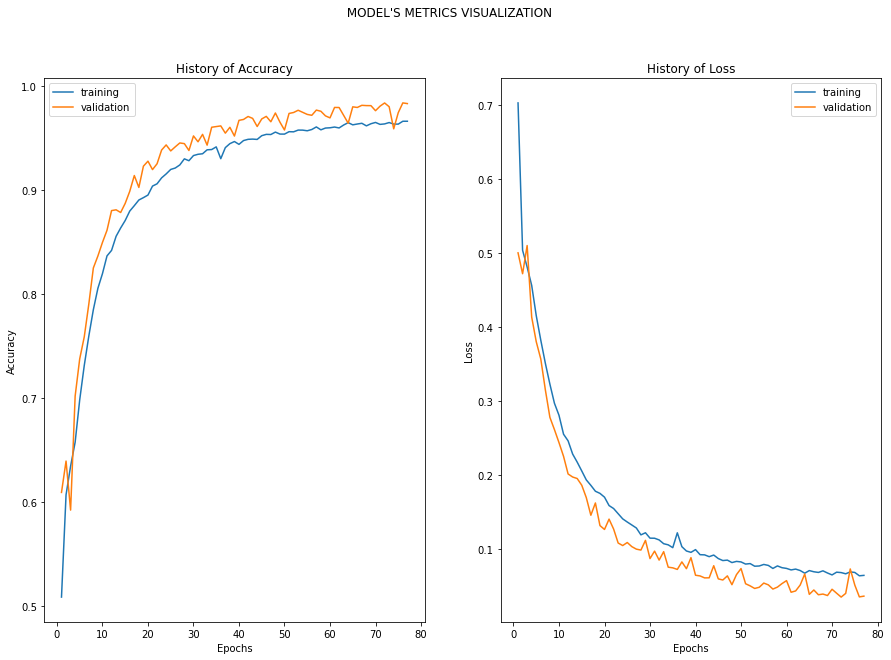

In [66]:
#%% PLOTTING RESULTS (Train vs Validation)
import matplotlib.pyplot as plt
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'])

In [76]:
y_pred=model.predict_classes(x_test)
y_test=[np.argmax(x) for x in y_test]
y_pred_prb=model.predict_proba(x_test)

In [77]:
print(y_test)
print(y_pred)

[0, 1, 1, 2, 1, 2, 0, 0, 0, 2, 2, 1, 1, 1, 0, 1, 0, 1, 1, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 1, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2, 2, 0, 0, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 0, 0, 0, 1, 0, 2, 2, 0, 1, 2, 2, 1, 0, 1, 0, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 0, 1, 0, 2, 1, 1, 0, 2, 1, 2, 0, 1, 2, 1, 0, 0, 1, 1, 0, 2, 1, 1, 1, 2, 2, 2, 1, 1, 0, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 0, 2, 0, 2, 1, 0, 1, 0, 0, 1, 2, 0, 2, 1, 0, 0, 2, 2, 0, 0, 1, 0, 1, 2, 0, 1, 2, 1, 1, 1, 2, 1, 1, 1, 0, 0, 1, 1, 2, 0, 2, 0, 2, 0, 1, 1, 1, 2, 2, 1, 1, 2, 0, 0, 1, 1, 2, 2, 0, 0, 0, 2, 0, 1, 1, 1, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 1, 2, 2, 1, 2, 2, 2, 0, 1, 2, 2, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 0, 2, 1, 2, 0, 1, 1, 0, 0, 1, 2, 0, 2, 0, 1, 2, 1, 1, 0, 1, 1, 0, 2, 2, 0, 1, 2, 0, 0, 1, 2, 2, 0, 2, 1, 2, 0, 0, 0, 1, 0, 2, 1, 1, 1, 2, 2, 0, 1, 0, 0, 0, 1, 0, 0, 1, 2, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 2, 1, 2, 0, 2, 2, 1, 2, 1, 2, 1, 0, 2, 0, 1, 1, 1, 0, 1, 0, 1, 0, 2, 1, 1, 0, 2, 

In [79]:
# def print_performance_metrics(y_test,y_pred):
#     """
#         parameters
#         ----------
#         y_test : actual label (must be in non-one hot encoded form)
#         y_pred_test : predicted labels (must be in non-one hot encoded form, common output of predict methods of classifers)

#         returns
#         -------
#         prints the accuracy, precision, recall, F1 score, ROC AUC score, Cohen Kappa Score, Matthews Corrcoef and classification report   
    
#     """
target=["F","G","D"]
from sklearn import metrics
print('Accuracy:', np.round(metrics.accuracy_score(y_test, y_pred),4))
print('Precision:', np.round(metrics.precision_score(y_test, y_pred, average='weighted'),4))
print('Recall:', np.round(metrics.recall_score(y_test,y_pred, average='weighted'),4))
print('F1 Score:', np.round(metrics.f1_score(y_test, y_pred, average='weighted'),4))
print('ROC AUC Score:', np.round(metrics.roc_auc_score(y_test, y_pred_prb,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test, y_pred),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test, y_pred,target_names=target))

Accuracy: 0.9805
Precision: 0.9805
Recall: 0.9805
F1 Score: 0.9805
ROC AUC Score: 0.9984
Cohen Kappa Score: 0.9708
		Classification Report:
               precision    recall  f1-score   support

           F       0.99      0.99      0.99      7703
           G       0.97      0.98      0.97      7525
           D       0.98      0.98      0.98      7956

    accuracy                           0.98     23184
   macro avg       0.98      0.98      0.98     23184
weighted avg       0.98      0.98      0.98     23184

